# Proyecto: Predicción del rendimiento académico de estudiantes con redes neuronales

# Autor: IGNACIO CICORIA

# Descripción

En este problema, se presenta un conjunto de datos que contiene información sobre el rendimiento académico de estudiantes universitarios, así como diversos factores que podrían influir en él. El objetivo es construir un modelo de regresión utilizando redes neuronales para predecir el índice de rendimiento académico de los estudiantes basado en las características proporcionadas.

El dataset proporcionado incluye las siguientes variables para cada estudiante:
* Hours Studied: El número total de horas dedicadas al estudio por cada estudiante.
* Previous Scores: Las puntuaciones obtenidas por los estudiantes en exámenes previos.
* Extracurricular Activities: Si el estudiante participa en actividades extracurriculares (Sí o No).
* Sleep Hours: El número promedio de horas de sueño que el estudiante tuvo por día.
* Sample Question Papers Practiced: El número de cuestionarios de muestra que el estudiante practicó.


Además, el dataset incluye la variable objetivo:
* Performance Index: Un índice que representa el rendimiento académico general de cada estudiante, redondeado al entero más cercano. Este índice varía de 10 a 100, donde valores más altos indican un mejor rendimiento.


# Análisis exploratorio


## Librerías

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

Establecer GPU por defecto

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

Carga del dataset


In [4]:
file_path = "https://raw.githubusercontent.com/guillericci/AA2-TP1-P1-CICORIA-RICCI/refs/heads/main/Student_Performance.csv"

df = pd.read_csv(file_path)

In [5]:
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


Procedemos a obtener información general del dataset. Variables involucradas, cantidad de registros no nulos y tipos de datos de las mismas.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


Podemos observar que no hay registros nulos.

Visualizamos las principales medidas descriptivas de las variables cuantitativas.

In [7]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


Observamos que no hay outliers.

Visualizamos la matriz de correlación para observar la relación lineal entre las variables cuantitativas.

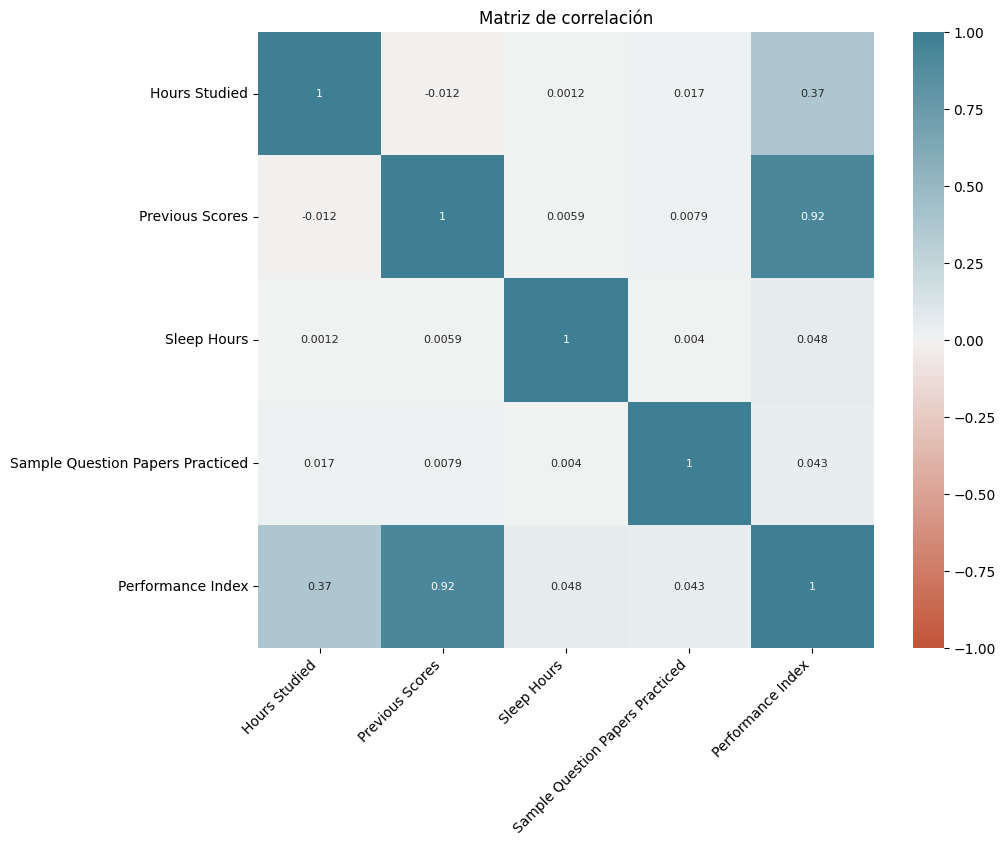

In [8]:
df_num = df.select_dtypes(include=['float64', 'int64'])
corr_matriz = df_num.corr()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr_matriz,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 8}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('Matriz de correlación')
plt.show()

Realizamos un gráfico de dispersión para observar gráficamente la relación lineal entre la target y las variables explicativas.

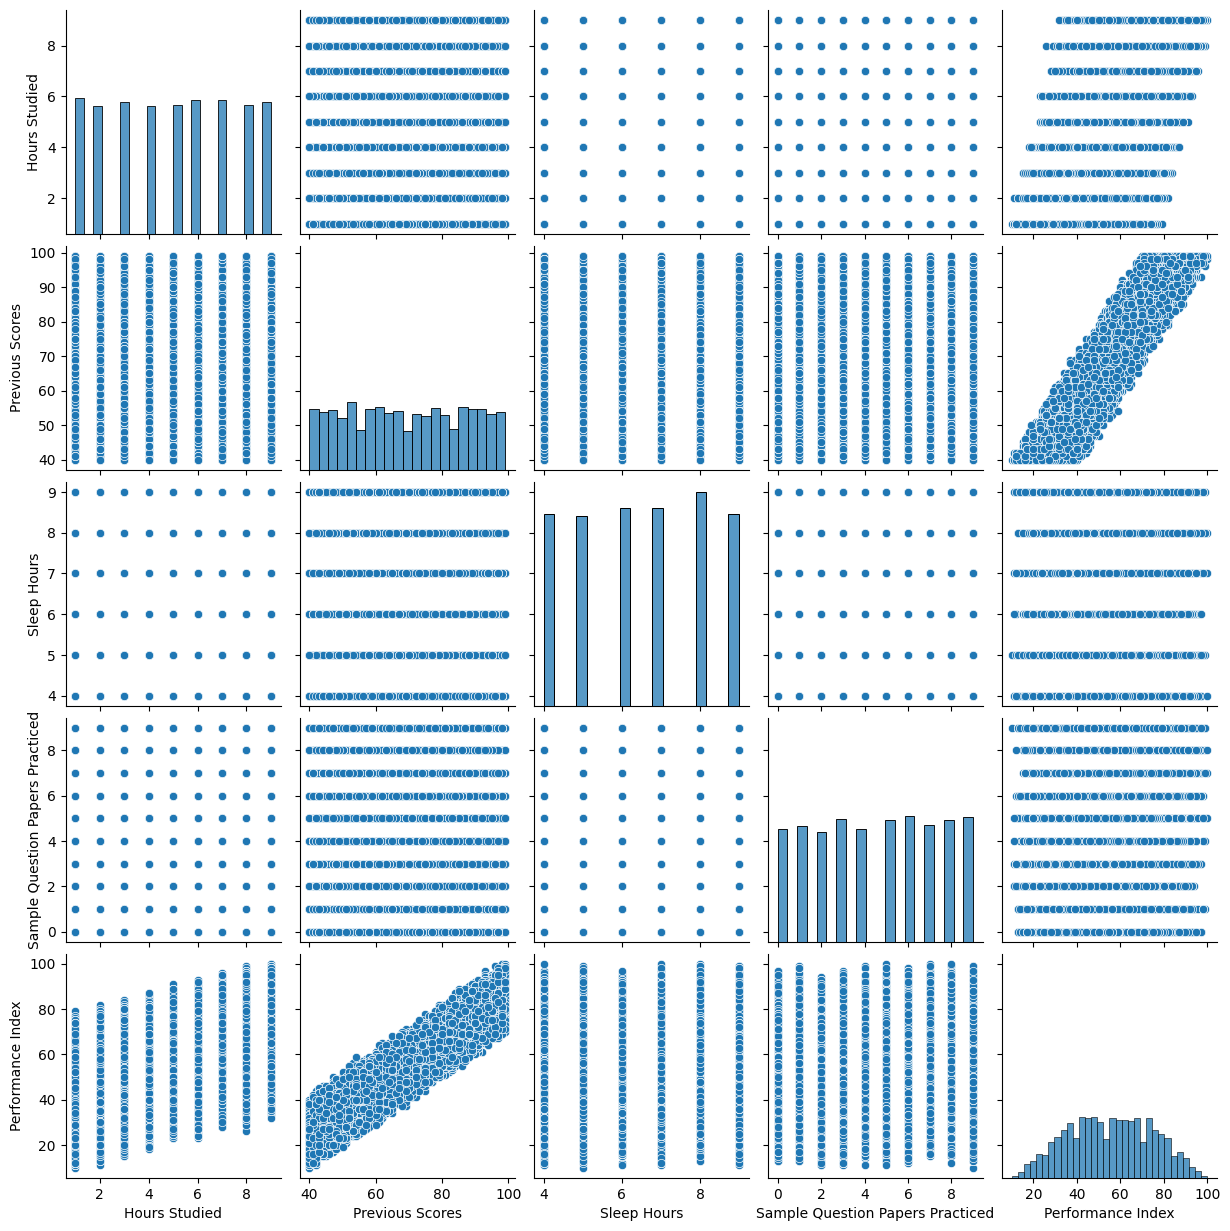

In [9]:
sns.pairplot(df_num)
plt.show()

Observamos un fuerte relación lineal de la target con "Previous Scores". También una considerable relación lineal con "Hours Studied". Con el resto de las variables explicativas cuantitativas la correlación es prácticamente nula.

Graficamos distintos boxplot de la target en función de la variable categórica "Extracurricular Activities".

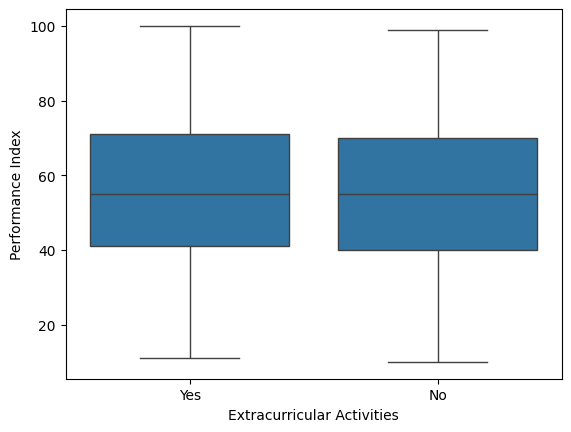

In [10]:
sns.boxplot(x="Extracurricular Activities", y="Performance Index", data=df)
plt.show()

A partir del gráfico, no se evidencian diferencias significativas en la distribución de la variable objetivo según la variable Extracurricular Activities, lo que sugiere que esta variable no tendría una influencia relevante sobre la target.

#División Train-Test

In [11]:
y = df['Performance Index']
X = df.drop('Performance Index', axis=1)

In [12]:
#División estratificada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Estandarización y Codificación

Procedemos a estandarizar las variables numéricas y codificar la categórica.

In [13]:
# --- Codificar variable categórica con BinaryEncoder ---
encoder = ce.BinaryEncoder(cols=["Extracurricular Activities"], return_df=True)
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

# --- Escalar variables numéricas ---
scaler = StandardScaler()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

X_train_enc[num_cols] = scaler.fit_transform(X_train_enc[num_cols])
X_test_enc[num_cols] = scaler.transform(X_test_enc[num_cols])

print(X_train_enc)


      Hours Studied  Previous Scores  Extracurricular Activities_0  \
9254       0.006455        -1.183844                             0   
1561      -1.149747        -1.241506                             1   
1670      -1.149747         0.661318                             0   
6087      -1.149747        -1.356828                             0   
6669       1.162658        -1.299167                             0   
...             ...              ...                           ...   
5734       1.162658        -1.126183                             1   
5191      -0.378946        -0.088279                             0   
5390       1.548059        -1.241506                             0   
860       -1.535148        -1.299167                             0   
7270      -1.149747        -1.356828                             0   

      Extracurricular Activities_1  Sleep Hours  \
9254                             1     0.269888   
1561                             0     0.269888   
1670  

#Modelado



Realizamos un primer modelo con todas las features.

In [14]:
model = Sequential([
    Input(shape=(X_train_enc.shape[1],)),
    Dense(32, activation='sigmoid'),
    Dense(16, activation='sigmoid'),
    Dense(1)  # activación lineal
])

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    X_train_enc, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1599.7448 - mae: 33.6157 - val_loss: 369.6605 - val_mae: 16.2960
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 313.3021 - mae: 14.4202 - val_loss: 35.7099 - val_mae: 3.6334
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 23.8080 - mae: 3.0425 - val_loss: 10.2879 - val_mae: 2.2198
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.6653 - mae: 2.1258 - val_loss: 6.6214 - val_mae: 1.8994
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4098 - mae: 1.9299 - val_loss: 5.7536 - val_mae: 1.8481
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.8623 - mae: 1.8779 - val_loss: 6.3522 - val_mae: 1.9441
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.3136 - mae: 1.8231 - val_loss: 6.1959 - val_mae: 1.9849
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.3639 - mae: 1.8292 - val_loss: 5.7562 - val_mae: 1.8933
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s

In [15]:
final_mae = history.history['mae'][-1]
final_val_mae = history.history['val_mae'][-1]

print(f"MAE MODELO 1 en entrenamiento: {final_mae:.4f}")
print(f"MAE MODELO 1 en validación: {final_val_mae:.4f}")


MAE MODELO 1 en entrenamiento: 1.7541
MAE MODELO 1 en validación: 1.7632


Realizamos un segundo modelo con un subset de features ("Previous Scores"-"Hours Studied")

In [16]:
X_train_enc_subset = X_train_enc[['Previous Scores', 'Hours Studied']]
X_test_enc_subset = X_test_enc[['Previous Scores', 'Hours Studied']]

In [17]:
model_2 = Sequential([
    Input(shape=(X_train_enc_subset.shape[1],)),
    Dense(32, activation='sigmoid'),
    Dense(16, activation='sigmoid'),
    Dense(1)  # activación lineal
])

model_2.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
model_2.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model_2.fit(
    X_train_enc_subset, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1593.7017 - mae: 33.6955 - val_loss: 164.6369 - val_mae: 9.1286
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 100.6225 - mae: 6.6528 - val_loss: 19.8284 - val_mae: 2.9415
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.7484 - mae: 2.7462 - val_loss: 9.3390 - val_mae: 2.2035
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.8857 - mae: 2.2329 - val_loss: 7.0795 - val_mae: 2.0394
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.2902 - mae: 2.1012 - val_loss: 6.8937 - val_mae: 2.0497
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8166 - mae: 2.0508 - val_loss: 7.0042 - val_mae: 2.0985
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3453 - mae: 1.9900 - val_loss: 6.1735 - val_mae: 1.9739
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3857 - mae: 2.0015 - val_loss: 5.8670 - val_mae: 1.9343
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

In [18]:
final_mae = history.history['mae'][-1]
final_val_mae = history.history['val_mae'][-1]

print(f"MAE MODELO 2 en entrenamiento: {final_mae:.4f}")
print(f"MAE MODELO 2 en validación: {final_val_mae:.4f}")


MAE MODELO 2 en entrenamiento: 1.9060
MAE MODELO 2 en validación: 1.9807


# Conclusión

Al comparar las métricas de ambos modelos, observamos que el segundo —entrenado únicamente con el subconjunto de variables "Previous Scores" y "Hours Studied"— presenta un MAE de 1.9807, ligeramente superior al del primer modelo (1.7632). Sin embargo, este segundo modelo resulta más conveniente, ya que logra un desempeño similar utilizando un conjunto reducido de características, lo que simplifica el modelo y mejora su interpretabilidad.
Además, al comparar las métricas de entrenamiento y prueba, se evidencia un buen ajuste del modelo y una buena capacidad de generalización, con un MAE de 1.9807 sobre una escala de 0 a 100, lo que representa un error promedio muy bajo en relación al rango de la variable objetivo.